### The work will consist in collecting data on dog breeds and then analyzing them using various graphs/tables, as well as clustering algorithms.

#### The relevance of the work lies in the fact that this analysis can help pet markets at the cross-country level to effectively distribute their products across countries (for example, in certain countries it is necessary to supply more food of a certain type depending on the height and weight of dogs that predominate there; or if dogs with long hair are common in the country, then it is necessary to supply more shampoos for long hair, etc.)

#### Based on the results of the work, it is planned to find out which dog breeds are common in different countries, cluster data on the weight and height of dogs using different methods and find out which one is the most suitable for this task.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats
import plotly.express as px
from kneed import KneeLocator
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.cluster.hierarchy as sch

In [2]:
import warnings
warnings.filterwarnings("ignore")

## We get data on dog breeds using parsing

(from the site https://petsi.net/dog-breeds)

In [3]:
# Для парсинга
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек
import time          # Библиотека для тайм-менеджмента
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

In [ ]:
# take all the links to specific dog breeds from the homepage

def getPageLinks():
    page_link = 'https://petsi.net/dog-breeds'
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
    if not response.ok:
        return []
    else:
        html = response.content
        soup = BeautifulSoup(html,'html.parser')
        hrefs = soup.findAll('div', attrs = {'class': "page-dog-breeds__list-item-wrapper"})
        hrefs = ['https://petsi.net' + link.find('a').attrs['href'] for link in hrefs]
        return hrefs                           

In [ ]:
# to identify the country where this breed of dog is most common

def getCountry(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_country = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_country.ok:
        return []
    else:
        html_country = response_country.content
        soup_country = BeautifulSoup(html_country,'html.parser')
        obj_country = soup_country.find('table', attrs={'class':"breed-view__table-info"})
        obj_country = obj_country.findAll('td')
        obj_country = [obj_country[td].text for td in range(len(obj_country))]
        if len(obj_country) != 0:
            for i in range(len(obj_country)):
                if 'Страна' in obj_country[i]:
                    return obj_country[i + 1].strip()
        return np.nan

In [ ]:
# output the life span

def getLifeExpectancy(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_life_expectancy = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_life_expectancy.ok:
        return []
    else:
        html_life_expectancy = response_life_expectancy.content
        soup_life_expectancy = BeautifulSoup(html_life_expectancy,'html.parser')
        obj_life_expectancy = soup_life_expectancy.find('table', attrs={'class':"breed-view__table-info"})
        obj_life_expectancy = obj_life_expectancy.findAll('td')
        obj_life_expectancy = [obj_life_expectancy[td].text for td in range(len(obj_life_expectancy))]
        if len(obj_life_expectancy) != 0:
            for i in range(len(obj_life_expectancy)):
                if 'Продолжительность' in obj_life_expectancy[i]:
                    return obj_life_expectancy[i + 1].strip().split()[0]
        return np.nan

In [ ]:
# to deduce the height (let's take only the age), since a dog cannot be of two sexes at the same time, and would have to
# either throw out one of the characteristics from the final dataset, or equate it to zero, which would cause inconvenience)

def getHeight(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_height = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_height.ok:
        return []
    else:
        html_height = response_height.content
        soup_height = BeautifulSoup(html_height,'html.parser')
        obj_height = soup_height.find('table', attrs={'class':"breed-view__table-info"})
        obj_height = obj_height.findAll('td')
        obj_height = [obj_height[td].text for td in range(len(obj_height))]
        if len(obj_height) != 0:
            for i in range(len(obj_height)):
                if 'Высота' in obj_height[i]:
                    return obj_height[i + 1].strip().split()[1]
        return np.nan

In [ ]:
# output the weight (similarly, we take only the weight of males)

def getWeight(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_weight = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_weight.ok:
        return []
    else:
        html_weight = response_weight.content
        soup_weight = BeautifulSoup(html_weight,'html.parser')
        obj_weight = soup_weight.find('table', attrs={'class':"breed-view__table-info"})
        obj_weight = obj_weight.findAll('td')
        obj_weight = [obj_weight[td].text for td in range(len(obj_weight))]
        if len(obj_weight) != 0:
            for i in range(len(obj_weight)):
                if 'Вес' in obj_weight[i]:
                    return obj_weight[i + 1].strip().split()[1]
        return np.nan

In [9]:
# output the length of the wool

def getCoatLength(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_coat_length = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_coat_length.ok:
        return []
    else:
        html_coat_length = response_coat_length.content
        soup_coat_length = BeautifulSoup(html_coat_length,'html.parser')
        obj_coat_length = soup_coat_length.find('table', attrs={'class':"breed-view__table-info"})
        obj_coat_length = obj_coat_length.findAll('td')
        obj_coat_length = [obj_coat_length[td].text for td in range(len(obj_coat_length))]
        if len(obj_coat_length) != 0:
            for i in range(len(obj_coat_length)):
                if 'шерс' in obj_coat_length[i]:
                    return obj_coat_length[i + 1].strip()
        return np.nan

In [10]:
# deduce the degree of reasonableness

def getIntelligence(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_intelligence = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_intelligence.ok:
        return []
    else:
        html_intelligence = response_intelligence.content
        soup_intelligence = BeautifulSoup(html_intelligence,'html.parser')
        obj_intelligence = soup_intelligence.find('div', attrs={'class': "param-dot-pane"})
        obj_intelligence = obj_intelligence.findAll('div', attrs={'class': "param-dot-pane-item__value"})
        new_obj_intelligence = []
        for element in obj_intelligence:
            new_element = element.find('span', attrs={'class': "clinic-card__stars br-wrapper br-theme-fontawesome-stars"})
            new_element_2 = new_element.find('span').get('class')
            new_obj_intelligence.append(new_element_2)
        obj_intelligence = [i[2] for i in new_obj_intelligence]
        obj_intelligence = obj_intelligence[3]
        obj_intelligence = obj_intelligence[-2:] if obj_intelligence[-2:] == '10' else obj_intelligence[-1] 
        return obj_intelligence

In [ ]:
# output dexterity

def getAgility(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_agility = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_agility.ok:
        return []
    else:
        html_agility = response_agility.content
        soup_agility = BeautifulSoup(html_agility,'html.parser')
        obj_agility = soup_agility.find('div', attrs={'class': "param-dot-pane"})
        obj_agility = obj_agility.findAll('div', attrs={'class': "param-dot-pane-item__value"})
        new_obj_agility = []
        for element in obj_agility:
            new_element = element.find('span', attrs={'class': "clinic-card__stars br-wrapper br-theme-fontawesome-stars"})
            new_element_2 = new_element.find('span').get('class')
            new_obj_agility.append(new_element_2)
        obj_agility = [i[2] for i in new_obj_agility]
        obj_agility = obj_agility[6]
        obj_agility = obj_agility[-2:] if obj_agility[-2:] == '10' else obj_agility[-1] 
        return obj_agility

In [ ]:
# output shedding

def getShedding(dog_link):
    time.sleep(0.3)
    UserAgent().chrome
    response_shedding = requests.get(dog_link, headers={'User-Agent': UserAgent().chrome})
    if not response_shedding.ok:
        return []
    else:
        html_shedding = response_shedding.content
        soup_shedding = BeautifulSoup(html_shedding,'html.parser')
        obj_shedding = soup_shedding.find('div', attrs={'class': "param-dot-pane"})
        obj_shedding = obj_shedding.findAll('div', attrs={'class': "param-dot-pane-item__value"})
        new_obj_shedding = []
        for element in obj_shedding:
            new_element = element.find('span', attrs={'class': "clinic-card__stars br-wrapper br-theme-fontawesome-stars"})
            new_element_2 = new_element.find('span').get('class')
            new_obj_shedding.append(new_element_2)
        obj_shedding = [i[2] for i in new_obj_shedding]
        obj_shedding = obj_shedding[7]
        obj_shedding = obj_shedding[-2:] if obj_shedding[-2:] == '10' else obj_shedding[-1] 
        return obj_shedding

In [ ]:
# collect data about each dog breed and combine the data into one dataframe

dogs = pd.DataFrame(columns=['Country', 'Life_Expectancy', 'Height', 'Weight', 'Coat_Length', 'Intelligence',
                                 'Agility', 'Shedding'])
for dog_link in getPageLinks():
        data_row = {'Country':getCountry(dog_link), 'Life_Expectancy':getLifeExpectancy(dog_link), 
                    'Height':getHeight(dog_link), 'Weight':getWeight(dog_link), 'Coat_Length':getCoatLength(dog_link),
                    'Intelligence':getIntelligence(dog_link), 'Agility':getAgility(dog_link), 
                    'Shedding': getShedding(dog_link)}
        dogs = dogs.append(data_row, ignore_index=True)
        time.sleep(0.3)

In [14]:
dogs

,Country,Life_Expectancy,Height,Weight,Coat_Length,Intelligence,Agility,Shedding
0,США,13-15,51-58,25-32,Средняя,9,8,8
1,Австралия,10-13,46-51,14-20,короткая,10,7,6
2,Австралия,12-15,23-28,7-8,Средняя,7,5,1
3,Австралия,13-15,46-51,15-16,Средняя,10,8,9
4,Мали,10-12,64-74,20-25,короткая,7,10,4
...,...,...,...,...,...,...,...,...
212,ЮАР,10-12,64-70,65-90,короткая,8,7,6
213,СССР,12-15,65-66,48-50,длинношерстная,8,6,7
214,Германия,13-15,33-40,9-10,короткая,10,8,7
215,Япония,12-16,25-30,1-5,длинношерстная,3,4,9


In [15]:
with pd.ExcelWriter('Dogs.xlsx') as writer:  
    dogs.to_excel(writer, sheet_name='Dogs')

In [18]:
dogs

,Country,Life_Expectancy,Height,Weight,Coat_Length,Intelligence,Agility,Shedding
0,США,13-15,51-58,25-32,Средняя,9,8,8
1,Австралия,10-13,46-51,14-20,короткая,10,7,6
2,Австралия,12-15,23-28,7-8,Средняя,7,5,1
3,Австралия,13-15,46-51,15-16,Средняя,10,8,9
4,Мали,10-12,64-74,20-25,короткая,7,10,4
...,...,...,...,...,...,...,...,...
212,ЮАР,10-12,64-70,65-90,короткая,8,7,6
213,СССР,12-15,65-66,48-50,длинношерстная,8,6,7
214,Германия,13-15,33-40,9-10,короткая,10,8,7
215,Япония,12-16,25-30,1-5,длинношерстная,3,4,9


## Converting the received data for further work

In [ ]:
# check the dataset for missing values
dogs.isnull().sum().sum()

In [132]:
dogs['Life_Expectancy'].unique()

array([14. , 11.5, 13.5, 11. ,  9. , 13. , 14.5, 15. , 10. , 12.5, 12. ,
       17. , 22.5, 10.5, 15.5, 16. ,  9.5, 16.5])

In [21]:
dogs.loc[dogs['Life_Expectancy'] == 'до']

,Country,Life_Expectancy,Height,Weight,Coat_Length,Intelligence,Agility,Shedding
211,Эстония,до,42-49,15-20,короткая,8,7,6


In [ ]:
# let's get rid of a breed that doesn't have a specified life span

dogs = dogs.drop([211], axis=0)

In [ ]:
# we will also delete breeds where the weight and height of dogs are not specified 

print(dogs[(dogs['Height'] == 'до') | (dogs['Weight'] == 'до')])
dogs = dogs.drop([93, 201], axis=0)

In [24]:
dogs['Coat_Length'].unique()

array(['Средняя', 'короткая', 'Короткая', 'средняя', 'бесшерстная',
       'длинная', 'длинношерстная', 'длинношерстая', 'лысая',
       'существует две разновидности: короткая и длинная',
       'встречаются длинношерстные и короткошерстные',
       'коротко- и длинношерстные'], dtype=object)

In [ ]:
# we will unify the names of extremely similar values of the "Coat_Length" column

dogs = dogs.replace({'Coat_Length': {"Короткая": "короткая", "Средняя": "средняя", "длинношерстная": "длинная", 
                                     "длинношерстая": "длинная", "лысая":"бесшерстная", 
                                     "существует две разновидности: короткая и длинная": "короткая и длинная",
                                    "встречаются длинношерстные и короткошерстные": "короткая и длинная",
                                    "коротко- и длинношерстные": "короткая и длинная", 
                                     "коротко- и длинношерстые": "короткая и длинная"}})

In [ ]:
# make sure that the values have become smaller

dogs['Coat_Length'].unique()

In [27]:
# now let's delete the rows that contain single values in the Weight and Height columns, so that instead of ranges, we can take the average life span, weight, and height by calculating 
# the arithmetic mean of the interval boundaries (for further convenience)

dogs['Height'].unique()

array(['51-58', '46-51', '23-28', '64-74', '64-70', '51-63', '61-66',
       '66-71', '50-70', '36-46', '25-46', '37-39', '33-53', '46-48',
       '56-64', '22,9—48,3', '74-81', '31-40', '38-41', '63-69', '61-68',
       '48-56', '25-30', '56-63', '52-56', '60-76', '23-30', '41-43',
       '30-38', '41-44', '60-66', '20-27', '33-41', '64-69', '56-60',
       '27-30', '65-72', '33-40', '60-67', '53-56', '30-45', '47-50',
       '58-69', '18-20', '76-112', '64-68', '45-55', '26-36', '65-75',
       '34-42', '62-67', '28-32', '36-39', '60-70', '34-41', '62-76',
       '55-66', '23-29', '63-80', '36-41', '71-76', '55-60', '56-61',
       '20-28', '68-72', '52-60', '55-62', '59-62', '75-90', '30-35',
       '58-67', '31-46', '77-88', '55-58', '30-33', '72-75', '58',
       '62-70', '48-58', '43-55', '25-33', '28-33', '46-65', '70-76',
       '62-66', '59-70', '67-89', '33-38', '72-80', '33-36', '25-28',
       '21-25', '38-40', '76-91', '46-60', '73-78', '63-77', '60-65',
       '76-86', '4

In [28]:
dogs_extra_height = dogs[(dogs['Height'] == '25') | (dogs['Height'] == '58') | (dogs['Height'] == '60')]
dogs_extra_height

,Country,Life_Expectancy,Height,Weight,Coat_Length,Intelligence,Agility,Shedding
97,"Канарский острова, Испания",8-12,58,45,короткая,6,7,1
184,Тибет,12-15,25,4-7,длинная,5,7,6
186,Япония,10-12,60,37-90,короткая,7,8,3


In [29]:
dogs['Weight'].unique()

array(['25-32', '14-20', '7-8', '15-16', '20-25', '32-39', '35-50',
       '36-43', '45-60', '32-54', '11-20', '5,5-7', '11-14', '31-120',
       '28-40', '29-34', '8,2-16', '50-65', '24-25', '12-15', '25-34',
       '28-35', '3-4', '27-34', '22-32', '45-54', '23-34', '3-6', '10-12',
       '8-11', '30-40', '30-37', '25-30', '38-50', '2-3,5', '10-11',
       '3-5', '41-50', '23-42', '30-34', '2,5-4', '60-70', '6-7', '55-70',
       '18-27', '32-45', '6,8-11,4', '13-16', '27-41', '70-90', '50-59',
       '22-38', '9-16', '45-70', '15-20', '14-17', '18-20', '8-10',
       '65-70', '20-29', '7-10', '40-50', '34-48', '18-23', '2-5',
       '45-85', '7,3-8,2', '27-40', '23-27', '27-32', '5-8', '34-45',
       '18-32', '27-36', '45-55', '16-18', '12-23', '10-16', '90-100',
       '35-38', '6-8', '60-90', '45', '45-50', '20-23', '4-5', '15-18',
       '22-35', '36-50', '45-52', '32-41', '15-21', '25-35', '48-75',
       '5-10', '68-113', '14-25', '33-40', '54-90', '14-18', '5-6',
       '6-14

In [30]:
dogs_extra_weight = dogs[(dogs['Weight'] == '3') | (dogs['Weight'] == '26') | (dogs['Weight'] == '45')]
dogs_extra_weight

,Country,Life_Expectancy,Height,Weight,Coat_Length,Intelligence,Agility,Shedding
97,"Канарский острова, Испания",8-12,58,45,короткая,6,7,1
164,Россия,15-18,20-28,3,короткая,6,9,4
198,"Чехословакия, Словакия",13-16,60-80,26,средняя,8,9,6


In [ ]:
# delete a few lines that violate data unification
dogs = dogs.drop([97, 184, 186, 97, 164, 198], axis = 0)

In [ ]:
# delete row 16, as there is a different dash between the numbers in the "Height" column

dogs = dogs.drop([16], axis = 0)

In [33]:
# replace the commas with dots so that the float conversion works when executing commands in the following field

dogs = dogs.replace({'Weight': {'5,5-7': '5.5-7', '2-3,5': '2-3.5', '2,5-4': '2.5-4', '6,8-11,4': '6.8-11.4', 
                                '7,3-8,2': '7.3-8.2', '5,9-7,7': '5.9-7.7', '1,5-3,5': '1.5-3.5', '2-2,5': '2-2.5',
                                '4,5-16': '4.5-16', '5,4-9,1': '5.4-9.1'}})

In [ ]:
# replacing the intervals with average values (for further convenience of working with data)

dogs['Life_Expectancy'] = dogs['Life_Expectancy'].apply(lambda x: (float(str(x).split('-')[0]) + float(str(x).split('-')[1]))/2)
dogs['Height'] = dogs['Height'].apply(lambda x: (float(str(x).split('-')[0]) + float(str(x).split('-')[1]))/2)
dogs['Weight'] = dogs['Weight'].apply(lambda x: (float(str(x).split('-')[0]) + float(str(x).split('-')[1]))/2) 

In [35]:
dogs

,Country,Life_Expectancy,Height,Weight,Coat_Length,Intelligence,Agility,Shedding
0,США,14.0,54.5,28.5,средняя,9,8,8
1,Австралия,11.5,48.5,17.0,короткая,10,7,6
2,Австралия,13.5,25.5,7.5,средняя,7,5,1
3,Австралия,14.0,48.5,15.5,средняя,10,8,9
4,Мали,11.0,69.0,22.5,короткая,7,10,4
...,...,...,...,...,...,...,...,...
212,ЮАР,11.0,67.0,77.5,короткая,8,7,6
213,СССР,13.5,65.5,49.0,длинная,8,6,7
214,Германия,14.0,36.5,9.5,короткая,10,8,7
215,Япония,14.0,27.5,3.0,длинная,3,4,9


## Summary statistics

In [133]:
dogs.describe()

,Life_Expectancy,Height,Weight,Intelligence,Agility,Shedding,long,middle,short,short and long
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,12.560096,51.427885,27.417788,7.062500,6.725962,5.163462,0.240385,0.346154,0.384615,0.014423
std,1.694690,16.810239,20.270471,2.469317,1.760242,2.761399,0.428348,0.476891,0.487678,0.119515
min,9.000000,19.000000,2.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,37.375000,10.500000,5.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,53.250000,24.750000,7.000000,7.000000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,13.500000,65.000000,35.750000,9.000000,8.000000,7.000000,0.000000,1.000000,1.000000,0.000000
max,22.500000,94.000000,95.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
# для применения различных методов машинного обучения применим One_Hot_Encoding к столбцу "Coat_Length"

dogs = dogs.join(pd.get_dummies(dogs['Coat_Length'], drop_first=True)) 
rename_cols={'длинная': 'long', 'короткая': 'short', 'короткая и длинная': 'short and long', 'средняя': 'middle'}
dogs = dogs.rename(columns = dict(rename_cols))
dogs = dogs.replace({'длинная': 'long', 'короткая': 'short', 'короткая и длинная': 'short and long', 'средняя': 'middle', 
                     'бесшерстная': 'hairless'})
dogs

,Country,Life_Expectancy,Height,Weight,Coat_Length,Intelligence,Agility,Shedding,long,middle,short,short and long
0,США,14.0,54.5,28.5,middle,9.0,8.0,8.0,0,1,0,0
1,Австралия,11.5,48.5,17.0,short,10.0,7.0,6.0,0,0,1,0
2,Австралия,13.5,25.5,7.5,middle,7.0,5.0,1.0,0,1,0,0
3,Австралия,14.0,48.5,15.5,middle,10.0,8.0,9.0,0,1,0,0
4,Мали,11.0,69.0,22.5,short,7.0,10.0,4.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
212,ЮАР,11.0,67.0,77.5,short,8.0,7.0,6.0,0,0,1,0
213,СССР,13.5,65.5,49.0,long,8.0,6.0,7.0,1,0,0,0
214,Германия,14.0,36.5,9.5,short,10.0,8.0,7.0,0,0,1,0
215,Япония,14.0,27.5,3.0,long,3.0,4.0,9.0,1,0,0,0


In [52]:
# преобразуем в числовой формат для дальнейшей возможности построения таблиц
dogs[['Intelligence', 'Agility', 'Shedding']] = dogs[['Intelligence', 'Agility', 'Shedding']].astype(float)

In [53]:
life_and_mind = pd.pivot_table(dogs, index=['Country'], values=['Life_Expectancy', 'Intelligence', 'Height', 'Weight'], aggfunc='mean')
life_and_mind.loc[life_and_mind['Intelligence'] == 10]
# самые умные собаки в Армении, Исландии, Мексике, Бурятии и т.д.

,Height,Intelligence,Life_Expectancy,Weight
Country,,,,
Армения,71.5,10.0,12.0,65.0
Исландия,38.5,10.0,14.5,13.0
Куба,26.0,10.0,14.0,3.5
Мексика,53.0,10.0,15.5,19.5
Россия (Бурятия),70.0,10.0,13.0,57.5
Словакия,62.0,10.0,13.5,40.0
"Швейцария, США",63.0,10.0,11.5,35.0


In [54]:
life_and_mind.loc[life_and_mind['Life_Expectancy'] >= 14] 
# самые долго живущие собаки в Мексике, Исландии и т.д.

,Height,Intelligence,Life_Expectancy,Weight
Country,,,,
Голландия,49.0,9.0,14.0,27.50
Исландия,38.5,10.0,14.5,13.00
Конго,42.0,5.0,14.0,11.00
Куба,26.0,10.0,14.0,3.50
Мадагаскар,27.5,5.0,15.0,6.25
Марокко,69.0,7.0,14.0,25.00
Мексика,53.0,10.0,15.5,19.50
США (Аляска),63.5,3.0,14.5,39.50


In [55]:
pd.pivot_table(dogs, index=['Coat_Length'], values=['Agility'], aggfunc=['mean', 'max'])
# весьма логично, что лысые породы собак более активны, поскольку нет шерсти, стесняющей их движений, 
# однако удивительно, что если шерть есть, то почти не важно, длинная она или короткая
# а вот породы, предполагающие оба типа шерсти, достаточно неактивны

,mean,max
,Agility,Agility
Coat_Length,,
hairless,9.666667,10.0
long,6.440000,10.0
middle,6.888889,10.0
short,6.775000,10.0
short and long,3.333333,4.0


In [56]:
pd.crosstab(index=dogs['Shedding'], columns=dogs['Coat_Length'], margins=True)
# например, собак с весьма средней линькой (4-6) чаще можно найти среди собак с короткой шерстью
# а вот с высокой - среди собак со средней и длинной шерстью, что довольно логично

Coat_Length,hairless,long,middle,short,short and long,All
Shedding,,,,,,
1.0,3,6,14,9,0,32
2.0,0,1,6,6,0,13
3.0,0,3,3,5,0,11
4.0,0,1,2,12,1,16
5.0,0,10,13,27,0,50
6.0,0,10,10,11,0,31
7.0,0,5,2,4,1,12
8.0,0,1,7,2,0,10
9.0,0,3,7,1,0,11


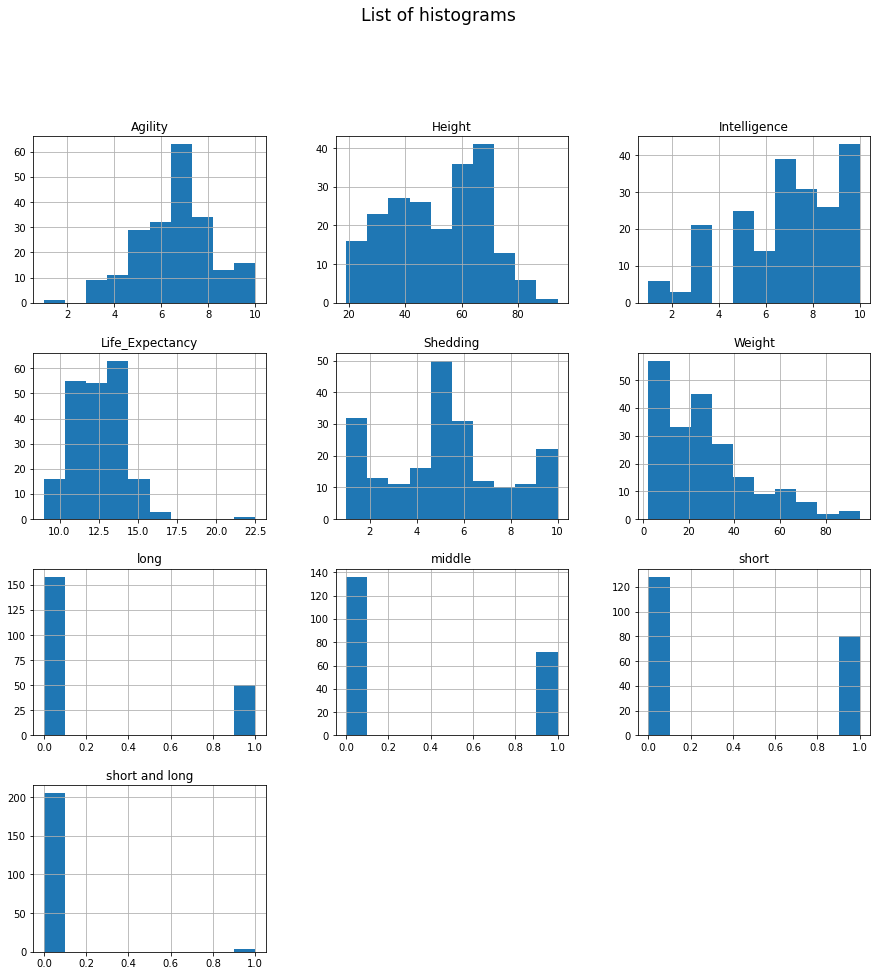

In [57]:
# выведем информацию по всем признакам (так, например, видно, что в выборке много "умных", небольших собак со средней степенью линьки)
fig = plt.figure(figsize = (15,15))
ax = fig.gca() #get current axis
dogs.hist(ax = ax)
plt.suptitle('List of histograms', x=0.5, y=1, ha='center', fontsize='xx-large');

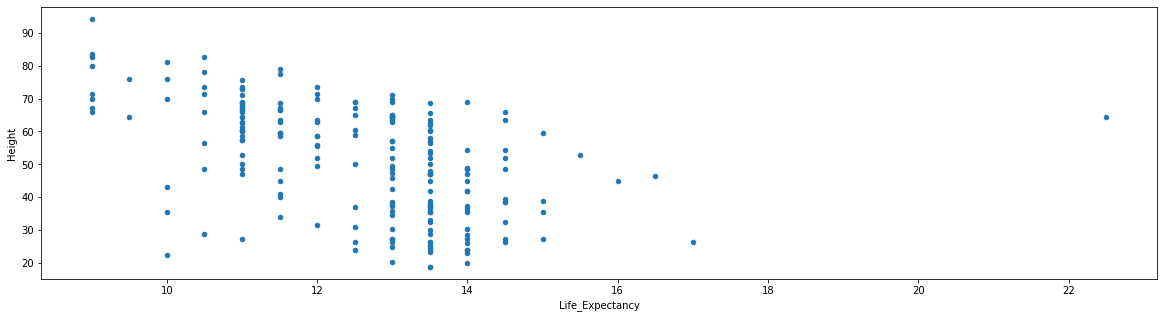

In [58]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
dogs.plot.scatter(x='Life_Expectancy', y='Height', ax=ax);
# например, среди собак, живущих в среднем около 11 лет, больше всего тех, чья высота колеблется примерно от 60 до 70 см

#### It is also possible to visualize using the plotly.express library, however, I do not have images displayed, so I have no way to comment on them.

In [59]:
fig = px.scatter(dogs, x = 'Height', y='Weight', color='Country')
fig.show()

In [60]:
fig = px.scatter_3d(df, x = 'Height', y='Weight', z='Intelligence', color='Country')
fig.show()

#### Correlation

In [61]:
scipy.stats.pearsonr(dogs.Height, dogs.Weight)

(0.837061424959735, 7.312005791168711e-56)

In [62]:
# выведем попарную корреляцию признаков
correlation = dogs.corr(method='pearson')
correlation

,Life_Expectancy,Height,Weight,Intelligence,Agility,Shedding,long,middle,short,short and long
Life_Expectancy,1.000000,-0.481275,-0.573208,0.119157,0.192594,-0.180699,0.103119,0.093686,-0.180080,-0.111633
Height,-0.481275,1.000000,0.837061,0.166125,0.213936,0.262824,0.027913,-0.065267,0.038462,0.053420
Weight,-0.573208,0.837061,1.000000,0.048423,-0.084578,0.276819,-0.006893,-0.081623,0.067183,0.168993
Intelligence,0.119157,0.166125,0.048423,1.000000,0.408518,0.087762,-0.009705,0.219476,-0.188546,-0.150394
Agility,0.192594,0.213936,-0.084578,0.408518,1.000000,-0.043415,-0.091609,0.067509,0.022078,-0.233719
Shedding,-0.180699,0.262824,0.276819,0.087762,-0.043415,1.000000,0.174912,0.033863,-0.161704,0.080649
long,0.103119,0.027913,-0.006893,-0.009705,-0.091609,0.174912,1.000000,-0.409311,-0.444730,-0.068052
middle,0.093686,-0.065267,-0.081623,0.219476,0.067509,0.033863,-0.409311,1.000000,-0.575224,-0.088020
short,-0.180080,0.038462,0.067183,-0.188546,0.022078,-0.161704,-0.444730,-0.575224,1.000000,-0.095637
short and long,-0.111633,0.053420,0.168993,-0.150394,-0.233719,0.080649,-0.068052,-0.088020,-0.095637,1.000000


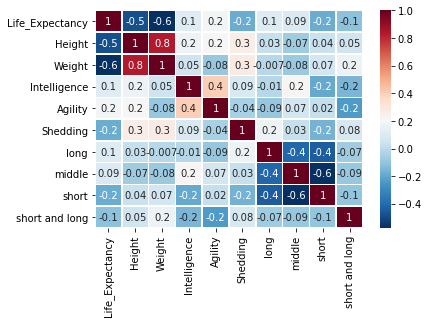

In [63]:
sb.heatmap(correlation, 
            xticklabels=correlation.columns,
            yticklabels=correlation.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            fmt='.1g');
# чрезвычайно сильно коррелирующих признаков нет, а значит, проблемы мультиколлинеарности возникнуть не должно ->
# -> не будем выкидывать ни один из признаков

##  Clusterisation

### K-MEANS

In [64]:
dogs_new = dogs.copy()
dogs_new.drop(['Coat_Length'], axis=1, inplace=True)

In [65]:
dogs_new

,Country,Life_Expectancy,Height,Weight,Intelligence,Agility,Shedding,long,middle,short,short and long
0,США,14.0,54.5,28.5,9.0,8.0,8.0,0,1,0,0
1,Австралия,11.5,48.5,17.0,10.0,7.0,6.0,0,0,1,0
2,Австралия,13.5,25.5,7.5,7.0,5.0,1.0,0,1,0,0
3,Австралия,14.0,48.5,15.5,10.0,8.0,9.0,0,1,0,0
4,Мали,11.0,69.0,22.5,7.0,10.0,4.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
212,ЮАР,11.0,67.0,77.5,8.0,7.0,6.0,0,0,1,0
213,СССР,13.5,65.5,49.0,8.0,6.0,7.0,1,0,0,0
214,Германия,14.0,36.5,9.5,10.0,8.0,7.0,0,0,1,0
215,Япония,14.0,27.5,3.0,3.0,4.0,9.0,1,0,0,0


In [66]:
# Масштабирование признаков
dogs_new_scaled = StandardScaler().fit_transform(dogs_new[['Life_Expectancy', 'Height', 'Weight', 'Intelligence',
                                 'Agility', 'Shedding', 'long', 'short', 'short and long', 'middle']])
dogs_new_scaled = pd.DataFrame(dogs_new_scaled, columns = ['Life_Expectancy', 'Height', 'Weight', 'Intelligence',
                                 'Agility', 'Shedding', 'long', 'short', 'short and long', 'middle'])

In [67]:
dogs_new_scaled

,Life_Expectancy,Height,Weight,Intelligence,Agility,Shedding,long,short,short and long,middle
0,0.851706,0.183194,0.053517,0.786523,0.725532,1.029689,-0.562544,-0.790569,-0.120972,1.374369
1,-0.627049,-0.174593,-0.515179,1.192470,0.156058,0.303671,-0.562544,1.264911,-0.120972,-0.727607
2,0.555955,-1.546107,-0.984972,-0.025372,-0.982891,-1.511374,-0.562544,-0.790569,-0.120972,1.374369
3,0.851706,-0.174593,-0.589357,1.192470,0.725532,1.392698,-0.562544,-0.790569,-0.120972,1.374369
4,-0.922800,1.047844,-0.243194,-0.025372,1.864480,-0.422347,-0.562544,1.264911,-0.120972,-0.727607
...,...,...,...,...,...,...,...,...,...,...
203,-0.922800,0.928582,2.476659,0.380576,0.156058,0.303671,-0.562544,1.264911,-0.120972,-0.727607
204,0.555955,0.839135,1.067281,0.380576,-0.413416,0.666680,1.777639,-0.790569,-0.120972,-0.727607
205,0.851706,-0.890166,-0.886068,1.192470,0.725532,0.666680,-0.562544,1.264911,-0.120972,-0.727607
206,0.851706,-1.426845,-1.207505,-1.649161,-1.552365,1.392698,1.777639,-0.790569,-0.120972,-0.727607


### Let's perform clusterization based on the attributes 'Height' and 'Weight' 

(that is, we will divide the sample by the size of the dogs)

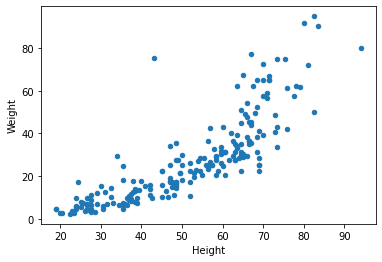

In [70]:
pd.DataFrame(dogs_new[['Height', 'Weight']]).plot.scatter(x=0, y=1);

In [135]:
#инициализируем алгоритм
kmeans2 = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
#применим алгоритм к нашим данным
kmeans2.fit(dogs_new[['Height', 'Weight']])

KMeans(init='random', n_clusters=2, random_state=42)

In [136]:
print('The lowest SSE value: ', kmeans2.inertia_)
print('Final locations of the centroid: ', kmeans2.cluster_centers_)
print('N_iter: ', kmeans2.n_iter_)
print('Classes:', kmeans2.labels_)

The lowest SSE value:  53995.97394230768
Final locations of the centroid:  [[65.52403846 42.64423077]
 [37.33173077 12.19134615]]
N_iter:  12
Classes: [0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0
 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1
 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1
 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1]


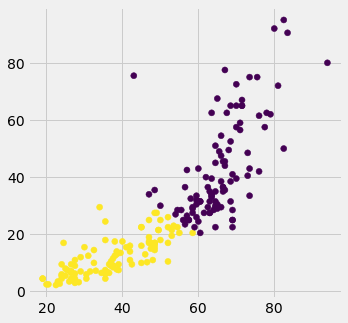

In [137]:
# красим сразу в цвета в соответствии с результатом модели, поскольку в связи с тем, что данные не сгенерированы, правильных ответов мы не знаем
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(dogs_new['Height'], dogs_new['Weight'], c=kmeans2.labels_)

#### Selecting the most accurate number of clusters

In [138]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10, max_iter=300,random_state=42)
    kmeans.fit(dogs_new[['Height', 'Weight']])
    sse.append(kmeans.inertia_)

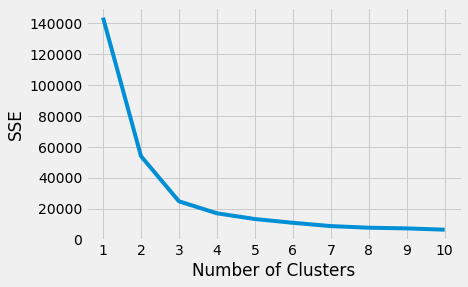

In [139]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [140]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

In [141]:
# Будем записывать в список значение коэффициента силуэта для каждого числа кластеров
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10, max_iter=300, random_state=42)
    kmeans.fit(dogs_new[['Height', 'Weight']])
    score = silhouette_score(dogs_new[['Height', 'Weight']], kmeans.labels_)
    silhouette_coefficients.append(score)

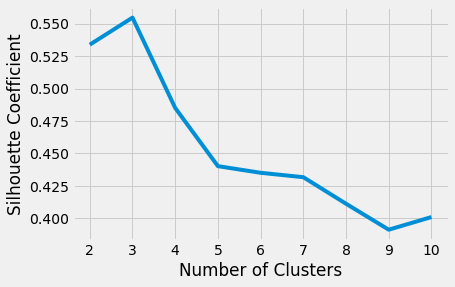

In [142]:
# убеждаемся, что метрика силуэта также указывает на то, что оптимальное число кластеров - 3 (там максимум функции)
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Thus, both methods show that the best number of clusters is 3

##### поэтому посмотрим на кластеризацию при делении на 3 кластера

In [143]:
#инициализируем алгоритм теперь уже с тремя кластерами
kmeans3 = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
#применим алгоритм к нашим данным
kmeans3.fit(dogs_new[['Height', 'Weight']])

KMeans(init='random', n_clusters=3, random_state=42)

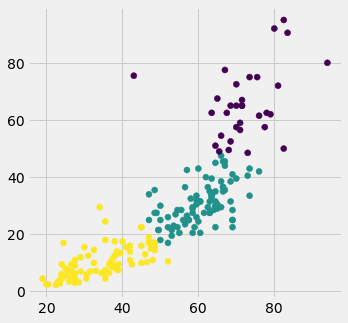

In [144]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(dogs_new['Height'], dogs_new['Weight'], c=kmeans3.labels_)

### DBSCAN

In [145]:
dbscan = DBSCAN(min_samples=3)
dbscan.fit(dogs_new[['Height', 'Weight']])

DBSCAN(min_samples=3)

In [146]:
dbscan.labels_

array([-1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3,
       -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1,  3,
       -1, -1, -1, -1, -1, -1, -1,  4, -1, -1,  5, -1, -1, -1, -1,  1, -1,
       -1, -1, -1,  6,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5,
       -1, -1, -1, -1,  0,  5, -1, -1, -1, -1,  6,  4, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        4, -1, -1, -1, -1,  2, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1])

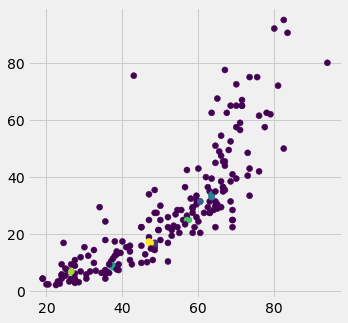

In [147]:
# видим, что DBSCAN решил задачу гораздо хуже
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(dogs_new['Height'], dogs_new['Weight'], c=dbscan.labels_)

In [148]:
eps = np.linspace(0.05,2,10)
neigh = list(range(1,12,1))
metrics = []
for e in eps:
    for n in neigh:
        dbscan = DBSCAN(min_samples=n, eps = e)
        dbscan.fit(dogs_new[['Height', 'Weight']])
        if (len(set(dbscan.labels_)) >1) and (len(set(dbscan.labels_)) < dogs_new[['Height', 'Weight']].shape[0]):
            a = (round(e,2), n, silhouette_score(dogs_new[['Height', 'Weight']], dbscan.labels_).round(2))
            print(a)
            metrics.append(list(a)[2])
print(max(metrics))
# таким образом, видно, что наилучшее значение коэффициента силуэта - это 0.22, которое достигается при эпсилон = 1.13 и min_samples = 1

(0.05, 1, 0.11)
(0.05, 2, -0.61)
(0.27, 1, 0.12)
(0.27, 2, -0.6)
(0.48, 1, 0.12)
(0.48, 2, -0.6)
(0.7, 1, 0.19)
(0.7, 2, -0.38)
(0.7, 3, -0.53)
(0.7, 4, -0.13)
(0.92, 1, 0.21)
(0.92, 2, -0.28)
(0.92, 3, -0.46)
(0.92, 4, -0.5)
(0.92, 5, -0.09)
(1.13, 1, 0.22)
(1.13, 2, -0.12)
(1.13, 3, -0.24)
(1.13, 4, -0.26)
(1.13, 5, -0.4)
(1.13, 6, -0.31)
(1.35, 1, 0.21)
(1.35, 2, -0.11)
(1.35, 3, -0.23)
(1.35, 4, -0.25)
(1.35, 5, -0.36)
(1.35, 6, -0.31)
(1.57, 1, 0.2)
(1.57, 2, -0.01)
(1.57, 3, -0.17)
(1.57, 4, -0.21)
(1.57, 5, -0.24)
(1.57, 6, -0.35)
(1.57, 7, -0.07)
(1.78, 1, 0.19)
(1.78, 2, 0.03)
(1.78, 3, -0.12)
(1.78, 4, -0.16)
(1.78, 5, -0.2)
(1.78, 6, -0.24)
(1.78, 7, -0.35)
(1.78, 8, -0.1)
(2.0, 1, 0.14)
(2.0, 2, 0.04)
(2.0, 3, -0.09)
(2.0, 4, -0.1)
(2.0, 5, -0.06)
(2.0, 6, -0.14)
(2.0, 7, -0.24)
(2.0, 8, -0.36)
(2.0, 9, -0.22)
0.22


In [149]:
dbscan_opt = DBSCAN(eps=1.13, min_samples=1)
dbscan_opt.fit(dogs_new[['Height', 'Weight']])

DBSCAN(eps=1.13, min_samples=1)

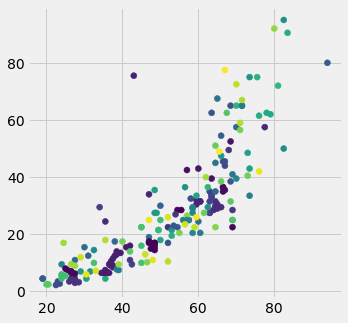

In [150]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(dogs_new['Height'], dogs_new['Weight'], c=dbscan_opt.labels_);

##### The separation has improved, but even with the naked eye you can see that this algorithm worked worse than the previous one.

### Hierarchical (agglomerative) clustering

In [151]:
agglomerative = AgglomerativeClustering(n_clusters=3)
agglomerative.fit(dogs_new[['Height', 'Weight']])

AgglomerativeClustering(n_clusters=3)

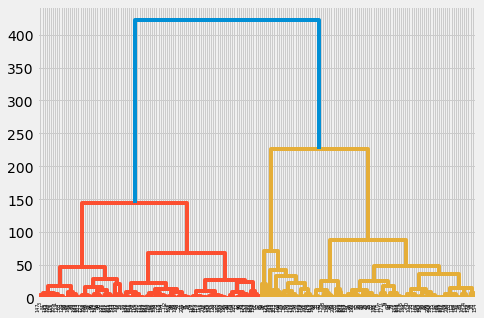

In [152]:
# Построим дендрограмму
plt.figure(figsize=(7,5))
dend = sch.dendrogram(sch.linkage(dogs_new[['Height', 'Weight']], method='ward'))
plt.show()

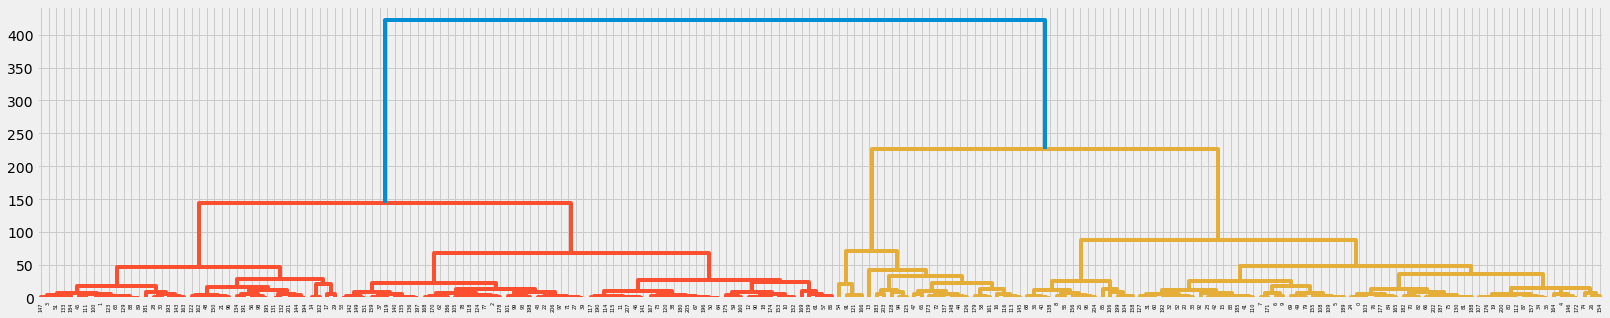

In [103]:
# Построим ту же дендрограмму, но немного в другом виде, чтобы были видны значения оси абсцисс
plt.figure(figsize=(25,5))
dend = sch.dendrogram(sch.linkage(dogs_new[['Height', 'Weight']], method='ward'))
plt.xticks(rotation='vertical')
plt.show()

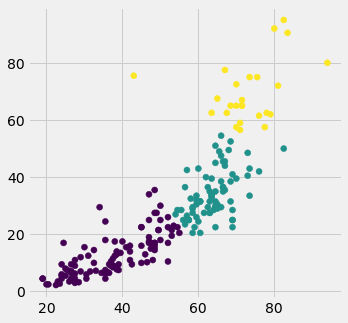

In [153]:
# видно, что данных метод справился примерно так же хорошо, как и k-means
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(dogs_new['Height'], dogs_new['Weight'], c=agglomerative.labels_);

### Summing up the results

In [154]:
# теперь сравним silhouette_score между ранее примененными методами (kmeans2, kmeans3, dbscan_opt, и agglomerative)
# dbscan не рассматриваем, так как он, очевидно, с задачей справился хуже
kmeans2_silhouette = silhouette_score(dogs_new[['Height', 'Weight']], kmeans2.labels_).round(2)
kmeans3_silhouette = silhouette_score(dogs_new[['Height', 'Weight']], kmeans3.labels_).round(2)
dbscan_opt_silhouette = silhouette_score(dogs_new[['Height', 'Weight']], dbscan_opt.labels_).round(2)
agglomerative_silhouette = silhouette_score(dogs_new[['Height', 'Weight']], agglomerative.labels_).round(2)

In [155]:
# приходим к выводу, что метод K-means решил задачу кластеризации все-таки немного лучше
print(kmeans2_silhouette)
print(kmeans3_silhouette)
print(dbscan_opt_silhouette)
print(agglomerative_silhouette)

0.53
0.55
0.22
0.52


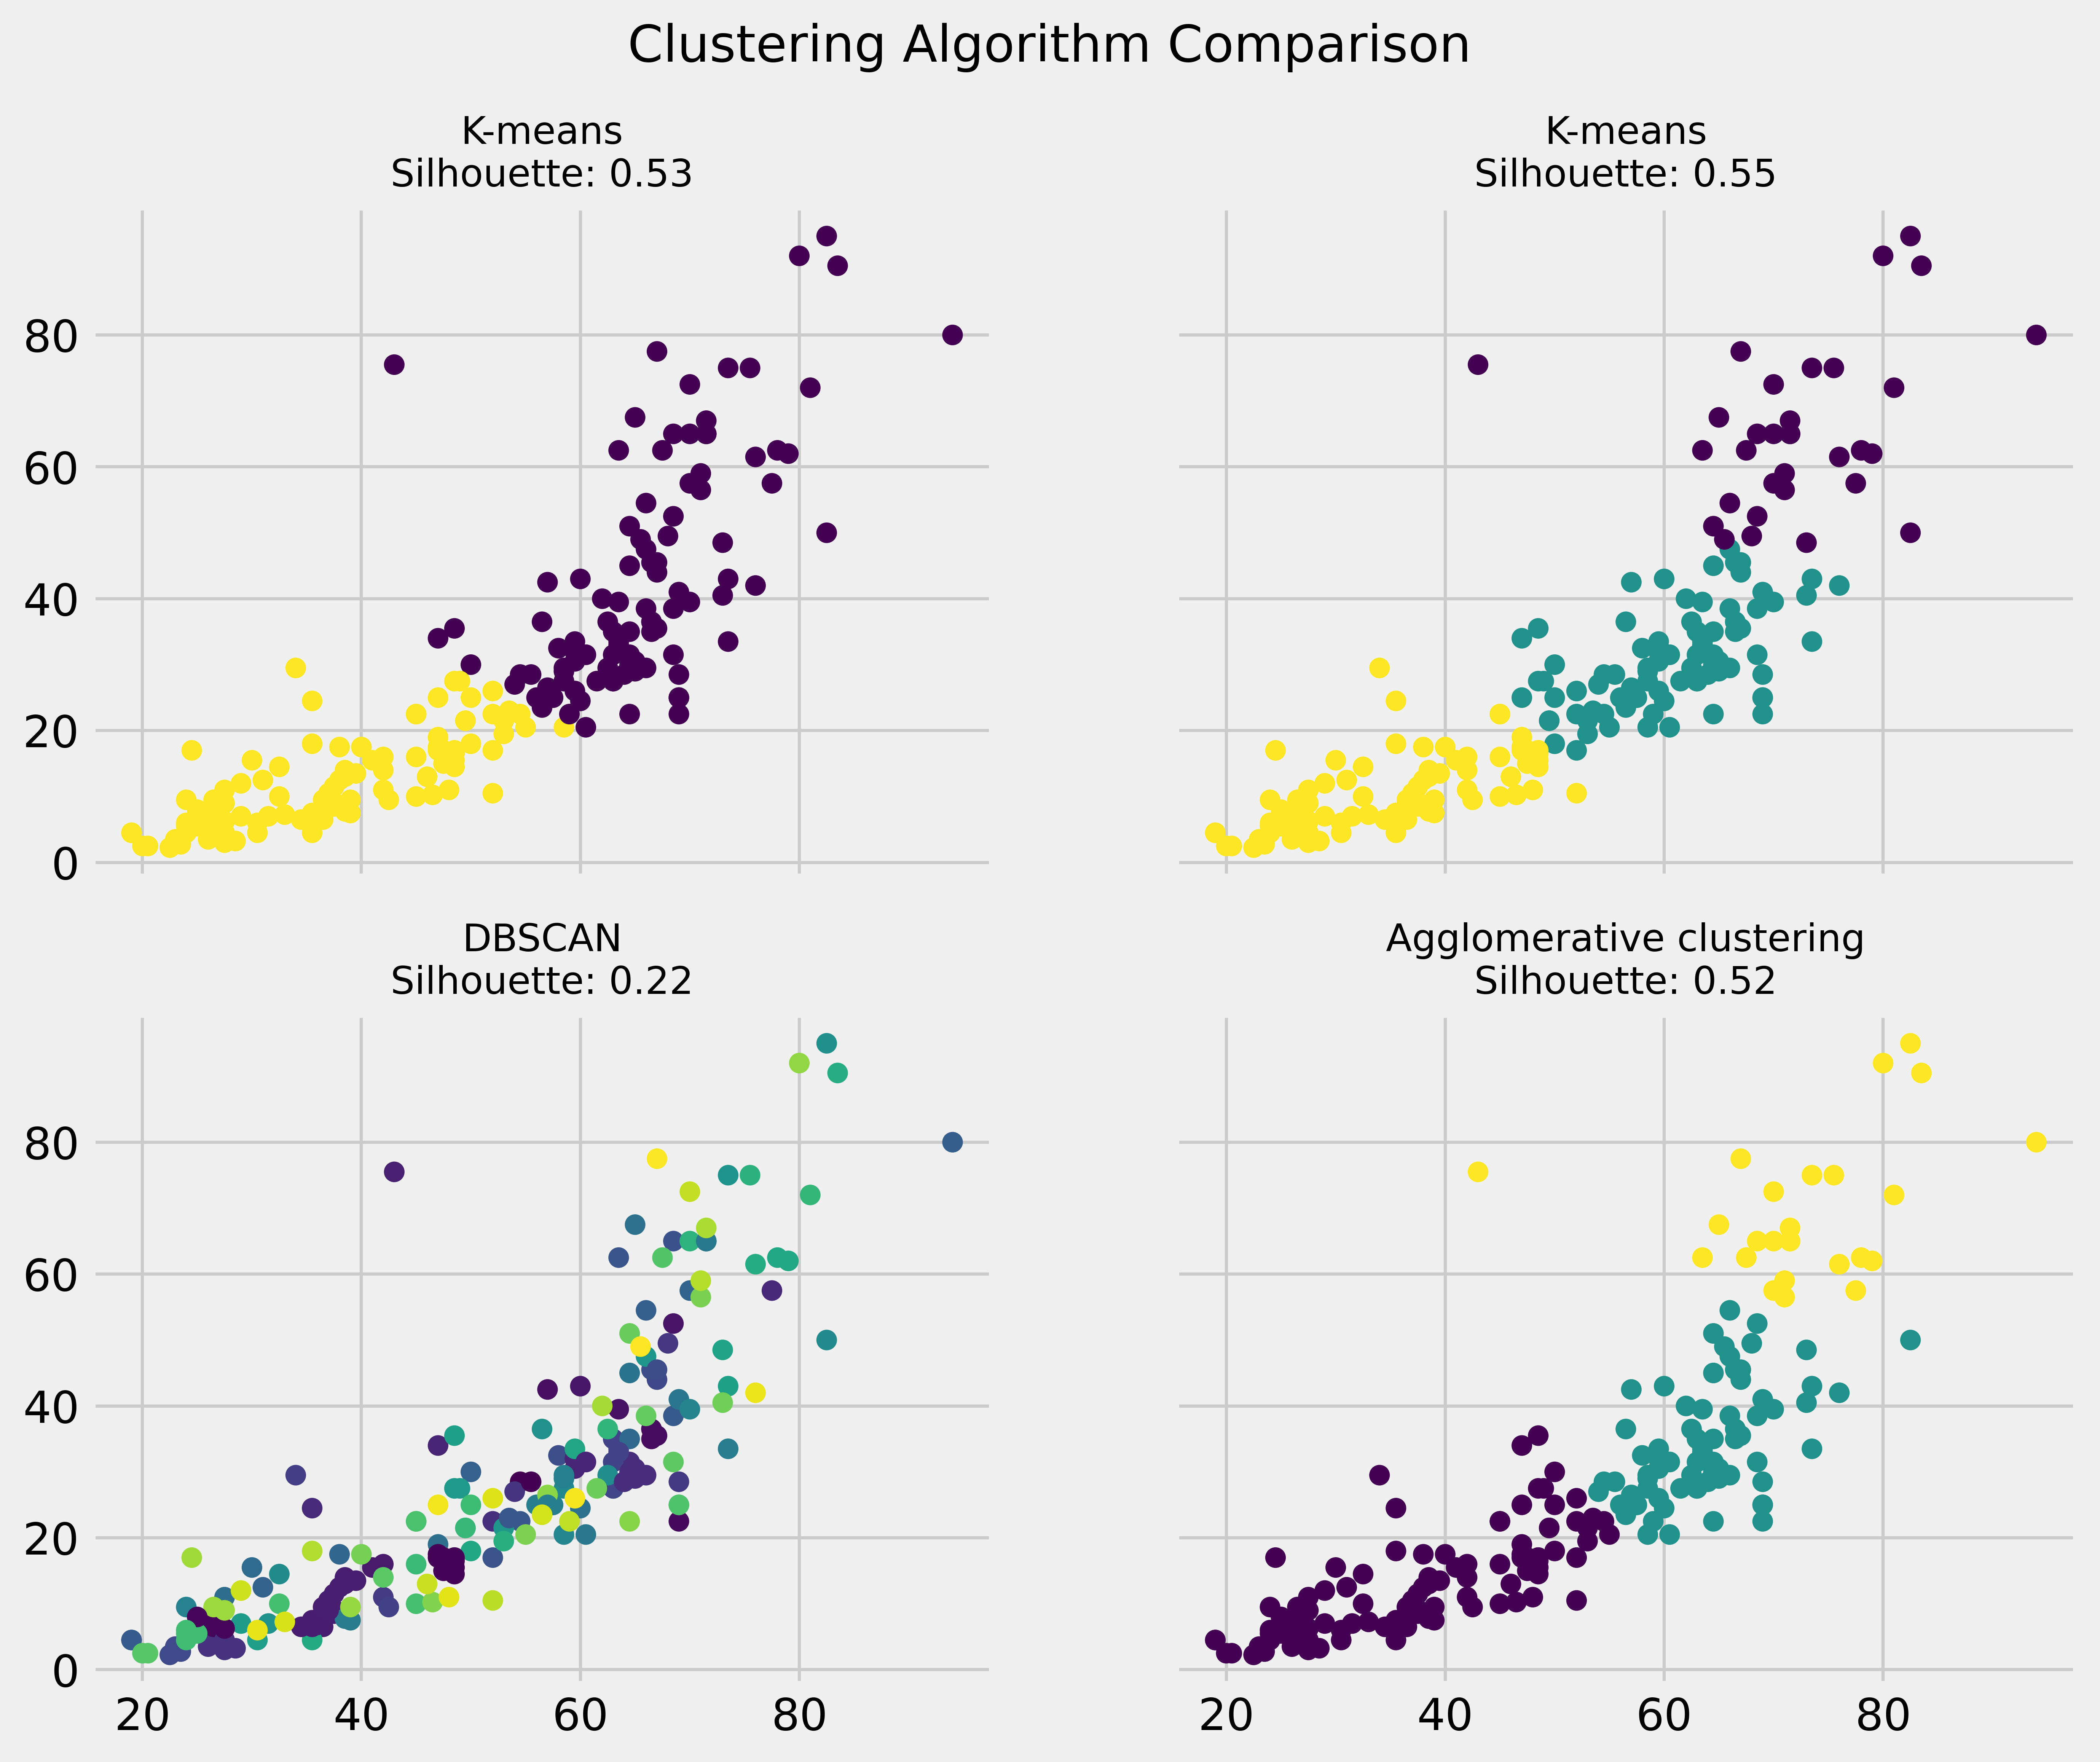

In [156]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True, dpi=600)
fig.suptitle(f"Clustering Algorithm Comparison", fontsize=16)

# The k-means plot (2 clasters)
ax[0,0].scatter(dogs_new['Height'], dogs_new['Weight'], c=kmeans2.labels_)
ax[0,0].set_title(f"K-means\nSilhouette: {kmeans2_silhouette}", fontdict={"fontsize": 12})

# The k-means plot (3 clasters)
ax[0,1].scatter(dogs_new['Height'], dogs_new['Weight'], c=kmeans3.labels_)
ax[0,1].set_title(f"K-means\nSilhouette: {kmeans3_silhouette}", fontdict={"fontsize": 12})

# The dbscan_opt plot
ax[1,0].scatter(dogs_new['Height'], dogs_new['Weight'], c=dbscan_opt.labels_)
ax[1,0].set_title(f"DBSCAN\nSilhouette: {dbscan_opt_silhouette}", fontdict={"fontsize": 12})

# The agglomerative plot
ax[1,1].scatter(dogs_new['Height'], dogs_new['Weight'], c=agglomerative.labels_)
ax[1,1].set_title(f"Agglomerative clustering\nSilhouette: {agglomerative_silhouette}", fontdict={"fontsize": 12})

plt.show()

#### Thus, it is clearly seen which methods coped well with the task; in particular, both k-means and agglomerative methods showed very similar results.

### As a result of the work done, I found out which dogs are common in different countries using pivot tables, etc.

### Also performed clustering by height and weight of dogs and compared different clustering methods